## Initialize Setup
---

In [30]:
import numpy as np
import os
from pathlib import Path
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import segmentation_models_pytorch as smp
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from segmentation_models_pytorch.metrics import get_stats, iou_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [31]:
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")    

Using device: mps


In [32]:
THRESHOLD = 0.5
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## Helper Function
---

In [33]:
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, multiclass=False):
        self.image_paths = list(image_paths)
        self.mask_paths  = list(mask_paths)
        self.transform = transform
        self.multiclass = multiclass

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, i):
        image = str(self.image_paths[i])
        mask = str(self.mask_paths[i])

        image = cv2.imread(image)
        if image is None:
            raise RuntimeError(f"cv2.imread failed for image: {image}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise RuntimeError(f"cv2.imread failed for mask: {mask}")

        if self.transform:
            try:
                out = self.transform(image=image, mask=mask)
            except Exception as e:
                raise RuntimeError(f"Augment failed for\n image: {image}\n mask: {mask}\n error: {e}")
            image, mask = out["image"], out["mask"]

        mask = torch.as_tensor(mask)
        mask = mask.long() if self.multiclass else mask.float()
        mask = (mask / 255.0).unsqueeze(0)  # to [0,1] and add channel dim
        return image, mask

In [34]:
def precision_score(tp, fp, fn, tn, eps=1e-7):
    return tp / (tp + fp + eps)

def recall_score(tp, fp, fn, tn, eps=1e-7):
    return tp / (tp + fn + eps)

In [35]:
def run_epoch(model,loader, threshold , loss_fn, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_iou, total_dice, total_prec, total_rec, n = 0.0, 0.0, 0.0, 0.0, 0.0, 0
    all_preds, all_targets = [], []

    for imgs, masks in loader:
        imgs, masks = imgs.to(device).float(), masks.to(device).float()
        if train:
            optimizer.zero_grad()

        # Forward pass
        logits = model(imgs)              # [B,1,H,W], raw logits
        loss   = loss_fn(logits, masks)   # scalar

        # ---- Predictions ----
        probs = torch.sigmoid(logits)       # [B,1,H,W]
        preds = (probs > threshold).long().squeeze(1)   # [B,H,W]
        targets = masks.long().squeeze(1)         # [B,H,W]

        # Collect for cm
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

        # ---- Metrics ----
        tp, fp, fn, tn = get_stats(preds, targets, mode="binary")
        iou  = iou_score(tp, fp, fn, tn, reduction="micro").item()
        dice = f1_score(tp, fp, fn, tn, reduction="micro").item()  # Dice == F1
        prec  = precision_score(tp.sum().item(), fp.sum().item(),
                                fn.sum().item(), tn.sum().item())
        rec   = recall_score(tp.sum().item(), fp.sum().item(),
                            fn.sum().item(), tn.sum().item())


        if train:
            loss.backward()
            optimizer.step()

        batch_size = imgs.size(0)
        total_loss += loss.item() * batch_size
        total_iou  += iou * batch_size
        total_dice += dice * batch_size
        total_prec += prec * batch_size
        total_rec  += rec * batch_size
        n += batch_size

    # ---- Final metrics ----
    print("all_preds[0] shape:", all_preds[0].shape)   # expect [B,H,W] or [H,W] if B==1
    print("concat shape:", np.concatenate(all_preds, axis=0).shape)  # expect [N,H,W]
    all_preds_con = np.concatenate(all_preds, axis=0)
    all_targets_con = np.concatenate(all_targets, axis=0)

    return {
        "loss":       total_loss / n,
        "iou":        total_iou  / n,
        "dice":       total_dice / n,
        "precision":  total_prec / n,
        "recall":     total_rec  / n,
        "preds":      all_preds_con,
        "targets":    all_targets_con,
    }

## Loading Data
---

In [36]:
data_dir = Path().cwd().parent / "dataset"
if not data_dir.exists():
    raise FileNotFoundError(f"Data directory {data_dir} does not exist.")

images_dir = data_dir / "images"
if not images_dir.exists():
    raise FileNotFoundError(f"Images directory {images_dir} does not exist.")
labels_dir = data_dir / "labels"
if not labels_dir.exists():
    raise FileNotFoundError(f"Labels directory {labels_dir} does not exist.")
masks_dir = data_dir / "masks"
if not masks_dir.exists():
    raise FileNotFoundError(f"Masks directory {masks_dir} does not exist.")

models_dir = Path().cwd() / "models"
if not models_dir.exists():
    models_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Images directory: {images_dir}")
print(f"Labels directory: {labels_dir}")
print(f"Masks directory: {masks_dir}")
print(f"Models directory: {models_dir}")

Data directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset
Images directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/images
Labels directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/labels
Masks directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/dataset/masks
Models directory: /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/u-net/models


### Check Image Mask pair

In [37]:
all_labels = set()

for jp in labels_dir.glob("*.json"):
    with open(jp, "r") as f:
        anno = json.load(f)
    for shape in anno.get("shapes", []):
        lbl = shape.get("label", "")
        all_labels.add(lbl)

print("Found labels:", all_labels)

Found labels: {'nerve', 'Nerve'}


In [38]:
CLASS_MAP = {"background": 0, "nerve": 1}

In [39]:
image_shapes = []
mask_shapes = []

for image in (images_dir.glob("*.png")):
    img = np.array(Image.open(image))
    image_shapes.append(img.shape[:2])  # (h, w)

for mask in masks_dir.glob("*.png"):
    m = np.array(Image.open(mask))
    mask_shapes.append(m.shape[:2])  # (h, w)

# check consistency
unique_image_shapes = set(image_shapes)
unique_mask_shapes = set(mask_shapes)

if len(unique_image_shapes) > 1:
    print("!!!!!!! Not all images have the same size:", unique_image_shapes)

if len(unique_mask_shapes) > 1:
    print("!!!!!!! Not all masks have the same size:", unique_mask_shapes)

if unique_image_shapes != unique_mask_shapes:
    print("!!!!!!! Image and mask sizes differ.")
else:
    print("All images and masks have the same size:", unique_image_shapes.pop())

All images and masks have the same size: (648, 864)


In [40]:
def safe_key(p):
    stem = p.stem
    return (0, int(stem)) if stem.isdigit() else (1, stem)

In [41]:
img_set  = sorted(images_dir.glob("*.png"), key=safe_key)
mask_set = sorted(masks_dir.glob("*.png"), key=safe_key)

# build dictionary: {"1": Path("masks/1.png"), "2": Path("masks/2.png"), ...}
mask_dict = {m.stem: m for m in mask_set}

# pair image with its mask if stem matches
pairs = [(p, mask_dict[p.stem]) for p in img_set if p.stem in mask_dict]

print(f"Found {len(pairs)} matched pairs.")
img_stems  = {p.stem for p in images_dir.glob("*.png")}
mask_stems = {p.stem for p in masks_dir.glob("*.png")}

# Images without masks
missing_masks = img_stems - mask_stems
print(f"X {len(missing_masks)} images without masks:")
for s in sorted(missing_masks):
    print(" -", s)
    
missing_images = mask_stems - img_stems
print(f"X {len(missing_images)} masks without images:")
for s in sorted(missing_images):
    print(" -", s)
    


Found 300 matched pairs.
X 0 images without masks:
X 0 masks without images:


In [42]:
imgs, masks = zip(*pairs)  # unzip into two lists

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    imgs, masks, test_size=0.3, random_state=SEED, shuffle=True
)

print(f"train images:{len(train_imgs)} \n valtest images:{len(val_imgs)}")

train images:210 
 valtest images:90


### Image Transformation

In [43]:
resize_to_256 = A.Resize(
    height=256, width=256,
    interpolation=cv2.INTER_LINEAR,
    mask_interpolation=cv2.INTER_NEAREST,
    area_for_downscale="image_mask"
)

train_transform = A.Compose([
    resize_to_256,
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.0, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

eval_transform = A.Compose([
    resize_to_256,
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [44]:
train_ds = SegDataset(train_imgs, train_masks, transform=train_transform, multiclass=False)  # set True if >1 class
val_ds   = SegDataset(val_imgs,   val_masks,   transform=eval_transform,  multiclass=False) # set True if >1 class
    
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=0, pin_memory=True)

In [45]:
sample_image, sample_mask = train_ds[0]  # Get processed sample
print(f"Processed image range: {sample_image.min():.3f} to {sample_image.max():.3f}")
print(f"Processed image shape: {sample_image.shape}")
print(f"Processed image dtype: {sample_image.dtype}")
print()
print(f"Processed mask range: {sample_mask.min():.3f} to {sample_mask.max():.3f}")
print(f"Processed mask shape: {sample_mask.shape}")
print(f"Processed mask dtype: {sample_mask.dtype}")

Processed image range: -2.118 to 1.594
Processed image shape: torch.Size([3, 256, 256])
Processed image dtype: torch.float32

Processed mask range: 0.000 to 1.000
Processed mask shape: torch.Size([1, 256, 256])
Processed mask dtype: torch.float32


### Making Cache dir

In [46]:
# pick cache dirs
hf_cache   = Path("./.cache/hf").resolve()
torch_cache= Path("./.cache/torch").resolve()
hf_cache.mkdir(parents=True, exist_ok=True)
torch_cache.mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"]   = str(hf_cache)     # for huggingface_hub
os.environ["TORCH_HOME"] = str(torch_cache) # for torch.hub

## Train model
---

In [47]:
model = smp.Linknet(encoder_name="resnet34", encoder_weights="imagenet",in_channels=3, classes=1).to(device)

# Binary losses/metrics
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss  = smp.losses.SoftBCEWithLogitsLoss()

def loss_fn(y_pred, y_true):
    return dice_loss(y_pred, y_true) + bce_loss(y_pred, y_true)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/Users/ratchanonkhongsawi/anaconda3/envs/monai_env/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading resnet34 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


In [65]:
MODEL_NAME = "linknet_v5.pt"

In [66]:
if (models_dir / MODEL_NAME).exists():
    raise FileExistsError(f"Model file {models_dir / MODEL_NAME} already exists. Please change MODEL_NAME to avoid overwriting.")

FileExistsError: Model file /Users/ratchanonkhongsawi/Desktop/CMKL/3rd/Computer Vision/project/Computer-vision-2025/u-net/models/linknet_v5.pt already exists. Please change MODEL_NAME to avoid overwriting.

In [ ]:
train_losses, val_losses = [], []
train_ious,   val_ious   = [], []
train_dices,  val_dices  = [], []

EPOCH = 30
PATIENCE = 3
counter = 0
best_model_state = None


best_val = float('inf')

for epoch in range(1, EPOCH + 1):
    # Training
    tr_metrics = run_epoch(model, train_loader, threshold=THRESHOLD, loss_fn=loss_fn, optimizer=optimizer, train=True)
    # Validation
    va_metrics = run_epoch(model, val_loader, threshold=THRESHOLD, loss_fn=loss_fn, optimizer=optimizer, train=False)

    # Save metrics
    train_losses.append(tr_metrics['loss'])
    val_losses.append(va_metrics['loss'])
    train_ious.append(tr_metrics['iou'])
    val_ious.append(va_metrics['iou'])
    train_dices.append(tr_metrics['dice'])
    val_dices.append(va_metrics['dice'])

    # Logging
    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_metrics['loss']:.4f} IoU {tr_metrics['iou']:.3f} Dice {tr_metrics['dice']:.3f} | "
        f"val loss {va_metrics['loss']:.4f} IoU {va_metrics['iou']:.3f} Dice {va_metrics['dice']:.3f}"
    )
    
    # Early stopping
    if va_metrics["loss"] < best_val:
        best_val = va_metrics["loss"]
        best_model_state = model.state_dict()  # save best weights
        counter = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print("Early stopping triggered!")
            break
        
if best_model_state:
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), models_dir / MODEL_NAME)

Epoch 01 | train loss 1.6516 IoU 0.015 Dice 0.029 | val loss 1.5269 IoU 0.034 Dice 0.065
Epoch 02 | train loss 1.3843 IoU 0.072 Dice 0.131 | val loss 1.3616 IoU 0.104 Dice 0.185
Epoch 03 | train loss 1.2749 IoU 0.161 Dice 0.270 | val loss 1.2780 IoU 0.170 Dice 0.286
Epoch 04 | train loss 1.2153 IoU 0.226 Dice 0.363 | val loss 1.2324 IoU 0.242 Dice 0.385
Epoch 05 | train loss 1.1765 IoU 0.264 Dice 0.411 | val loss 1.2166 IoU 0.284 Dice 0.439
Epoch 06 | train loss 1.1435 IoU 0.293 Dice 0.448 | val loss 1.1754 IoU 0.299 Dice 0.457
Epoch 07 | train loss 1.1169 IoU 0.308 Dice 0.465 | val loss 1.1472 IoU 0.314 Dice 0.475
Epoch 08 | train loss 1.0933 IoU 0.332 Dice 0.492 | val loss 1.0932 IoU 0.331 Dice 0.493
Epoch 09 | train loss 1.0720 IoU 0.347 Dice 0.509 | val loss 1.0843 IoU 0.296 Dice 0.453
Epoch 10 | train loss 1.0504 IoU 0.386 Dice 0.549 | val loss 1.0499 IoU 0.356 Dice 0.519
Epoch 11 | train loss 1.0277 IoU 0.407 Dice 0.571 | val loss 1.0659 IoU 0.186 Dice 0.309
Epoch 12 | train loss

## Visualize Result
---

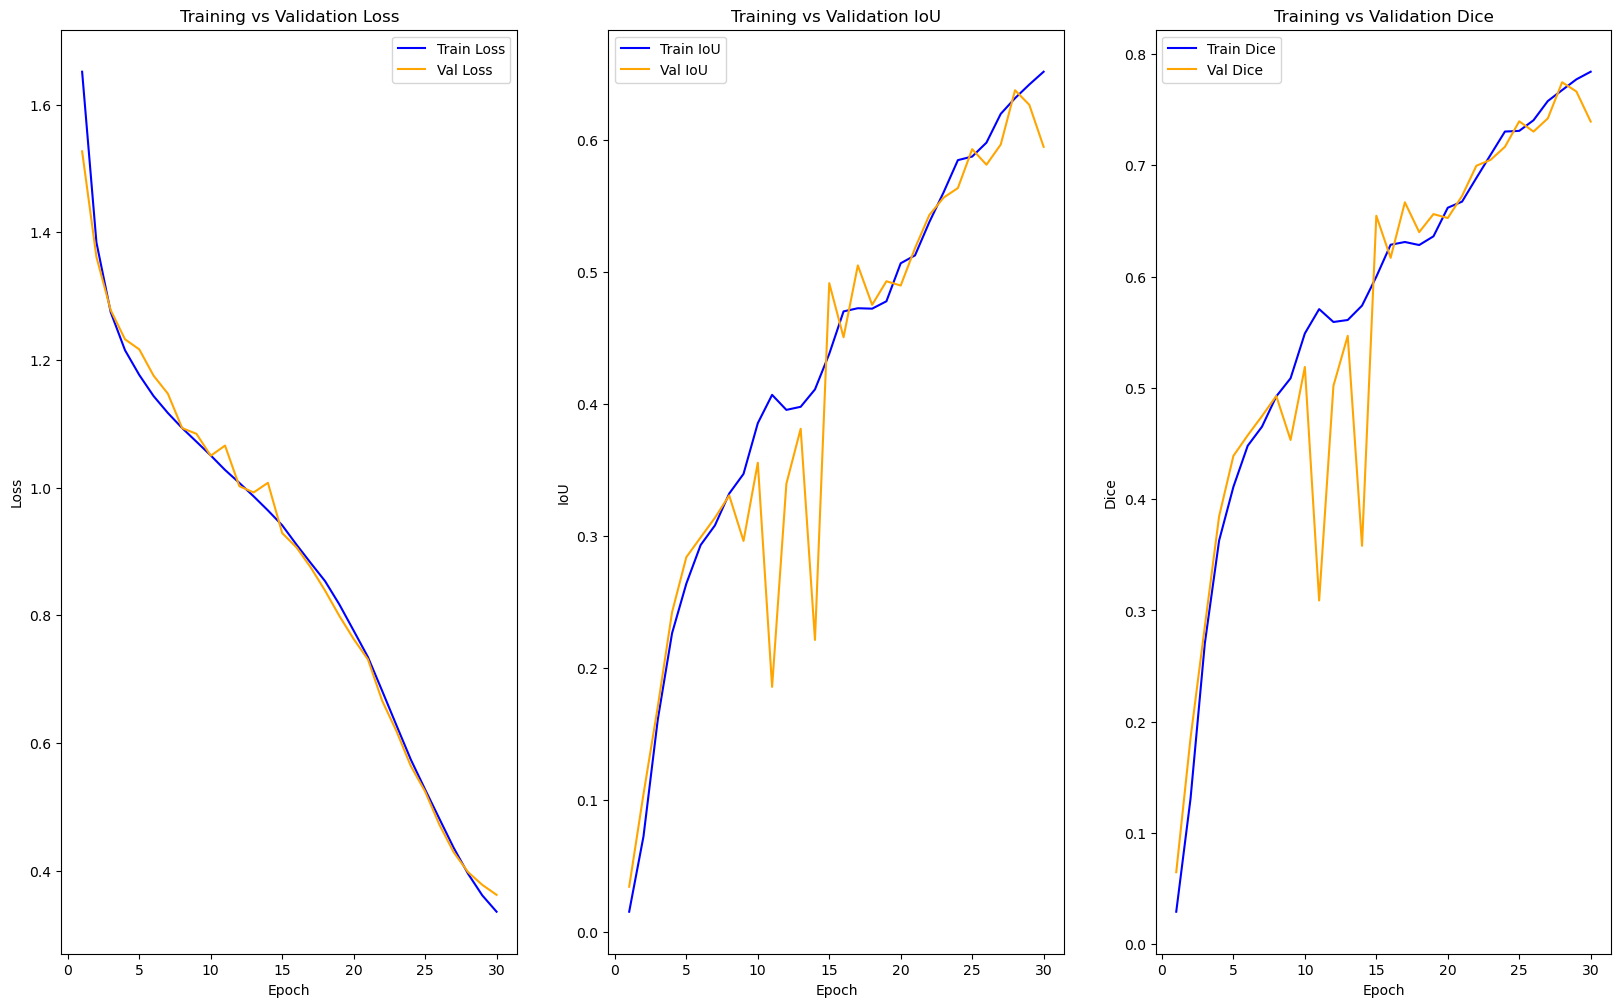

In [60]:
epochs = range(1, len(train_losses) + 1)

fig, axs = plt.subplots(1, 3, figsize=(20, 12))

axs[0].plot(epochs, train_losses, label="Train Loss", color='blue')
axs[0].plot(epochs, val_losses, label="Val Loss", color='orange')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training vs Validation Loss")
axs[0].legend()

axs[1].plot(epochs, train_ious, label="Train IoU", color='blue')
axs[1].plot(epochs, val_ious, label="Val IoU", color='orange')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("IoU")
axs[1].set_title("Training vs Validation IoU")
axs[1].legend()

axs[2].plot(epochs, train_dices, label="Train Dice", color='blue')
axs[2].plot(epochs, val_dices, label="Val Dice", color='orange')
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Dice")
axs[2].set_title("Training vs Validation Dice")
axs[2].legend()

plt.show()

In [61]:
print(f"Dice coef: {va_metrics['dice']:.3f}, IoU: {va_metrics['iou']:.3f}, Precision: {va_metrics['precision']:.3f}, Recall: {va_metrics['recall']:.3f}")

Dice coef: 0.739, IoU: 0.595, Precision: 0.669, Recall: 0.864


In [62]:
cm = confusion_matrix(va_metrics["targets"], va_metrics["preds"])  
cm_normalized = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

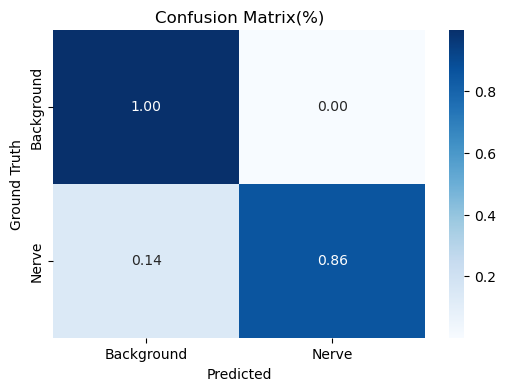

In [63]:
# Plot with seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Background", "Nerve"], yticklabels=["Background", "Nerve"])
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix(%)")
plt.show()

In [ ]:
if MODEL_NAME is None:
    raise ValueError("MODEL_NAME is not set.")

model = smp.Linknet(encoder_name="resnet34", encoder_weights=None,in_channels=3, classes=1).to(device)
model.load_state_dict(torch.load(models_dir / MODEL_NAME, map_location=device))

<All keys matched successfully>

In [52]:
result = run_epoch(model, val_loader, threshold=THRESHOLD, loss_fn=loss_fn, optimizer=optimizer, train=False)
preds = result["preds"]
targets = result["targets"]

all_preds[0] shape: (2, 256, 256)
concat shape: (90, 256, 256)


In [53]:
preds.shape

(90, 256, 256)

In [54]:
sample_pred1 = []
sample_target1 = []

for i in range(10):
    sample = np.random.randint(0, len(preds)-1)
    sample_pred1.append(preds[sample])
    sample_target1.append(targets[sample])

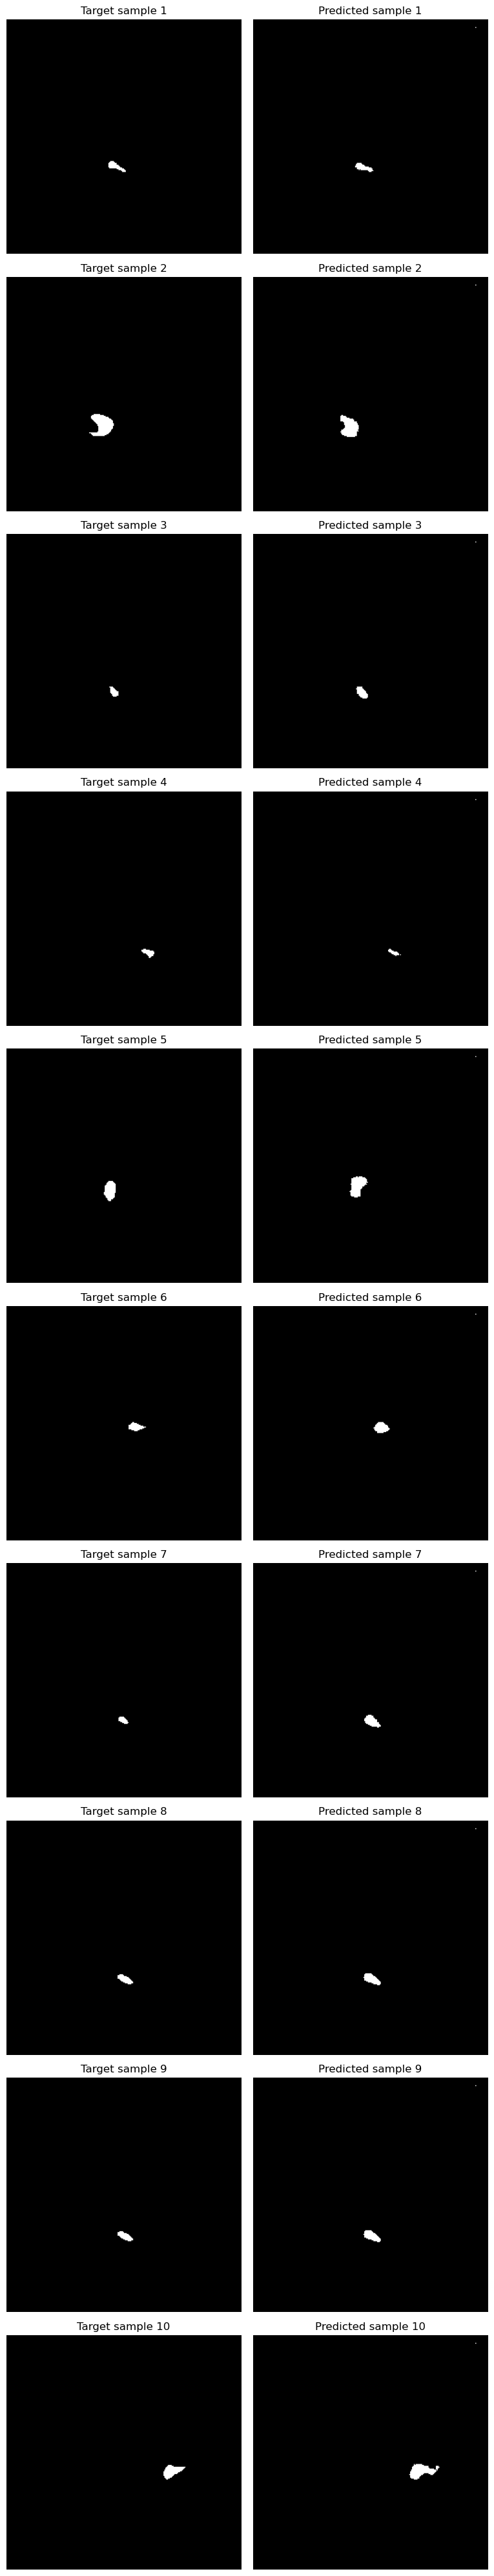

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(8, 40))

for i in range(10):
    axs[i, 0].imshow(sample_target1[i], cmap='gray')
    axs[i, 0].set_title(f'Target sample {i+1}')
    axs[i, 0].axis("off")

    axs[i, 1].imshow(sample_pred1[i], cmap='gray')
    axs[i, 1].set_title(f'Predicted sample {i+1}')
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()